# Flower classification with TPUs

## Problem
This kernel is to show how to use TPUs to classify images of 104 types of flowers. In this competition we need to classify the flowers based on their images drawn from five different public datasets. Some classes are very narrow, containing only a particular sub-type of flower (e.g. pink primroses) while other classes contain many sub-types (e.g. wild roses).

## Data
The images are provided in the competition dataset "flower-classification-with-tpus" in TFRecord format. This particular format is frequently used in Tensorflow to group and shard data files. Each file contains an id, label(class of flower) and img(pixels in array form).

1. train/*.tfrec - training samples with labels.
2. val/*.tfrec    - validation samples with labels.
3. test/*.tfrec   - test samples without labels.

## Overview

The details of the competition can be find in the following link :
> [Flower Classification with TPUs](https://www.kaggle.com/c/flower-classification-with-tpus/overview)> 

The kernel includes basic EDA(Exploratory Data Analysis) and models to classify the flowers to their correct category.

## Solution

I've used an ensemble model of DensetNet201 and EfficientNet-B7.

* A model of DensetNet201 pre-trained on the "imagenet" dataset with a softmax activation function.
* A model of EfficientNet-B7 pre-trained on the "noisy-student" dataset with a softmax activation function.
* Adam optimizer for learning rate optimization in both the models.
* Sparse Categorical Crossentropy as the loss function. 

## Notes

* There were multiple external datasets which were created during the competition. But unfortunately some of the test images were present in  these public external dataset. As a result of this, it was notified that external datasets were to be used only if these datasets were clean and free of any test image. Hence, I've not used the external dataset in this kernel. However, I'll attach some very useful kernels which shows the usage of external dataset. 

* You will see that the validation data is being integrated with the training data in the kernel. This is being done to show that including validation data can help in better performance in the leaderboard. However, this should not be done in real time projects as it can give you wrong sense of model performance. You can set the variable "USE_VALIDATION_DATA" to True/False to see the difference in the performances.

## Acknowledgment

I'd like to thank authors of the below kernels. These kernels were very helpful in understanding how to work with TPUs in this Playground Competition :


1. [Getting started with 100+ flowers on TPU by Martin Görner](https://www.kaggle.com/mgornergoogle/getting-started-with-100-flowers-on-tpu)
2. [TPU flowers - First Love by Roman Weilguny](https://www.kaggle.com/romanweilguny/tpu-flowers-first-love)
3. [gold medalRotation Augmentation GPU/TPU - [0.96+] by Chris Deotte](https://www.kaggle.com/cdeotte/rotation-augmentation-gpu-tpu-0-96)
4. [EfficientNet-With-All-5-Imagesets-S1 by Haveri](https://www.kaggle.com/haveri/efficientnet-with-all-5-imagesets-s1)

## Dependencies

In [1]:
!pip install -q efficientnet
import math, re, os
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
import efficientnet.tfkeras as efn
from matplotlib import pyplot as plt
from kaggle_datasets import KaggleDatasets
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
print("Tensorflow version " + tf.__version__)
AUTO = tf.data.experimental.AUTOTUNE

Tensorflow version 2.1.0


# TPU Configuration

Please read the below document given by Kaggle for better understanding of the below configuration:

[Tensor Processing Units (TPUs)](https://www.kaggle.com/docs/tpu)

In [2]:
# Detect hardware, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection. No parameters necessary if TPU_NAME environment variable is set. On Kaggle this is always the case.
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() # default distribution strategy in Tensorflow. Works on CPU and single GPU.

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.0.0.2:8470
REPLICAS:  8


## TPU variables initialization

In [3]:
# Data access ...
GCS_DS_PATH = KaggleDatasets().get_gcs_path('flower-classification-with-tpus')

IMAGE_SIZE = [512, 512] # at this size, a GPU will run out of memory. Use the TPU
BATCH_SIZE = 16 * strategy.num_replicas_in_sync

GCS_PATH_SELECT = { # available image sizes
    192: GCS_DS_PATH + '/tfrecords-jpeg-192x192',
    224: GCS_DS_PATH + '/tfrecords-jpeg-224x224',
    331: GCS_DS_PATH + '/tfrecords-jpeg-331x331',
    512: GCS_DS_PATH + '/tfrecords-jpeg-512x512'
}
GCS_PATH = GCS_PATH_SELECT[IMAGE_SIZE[0]]

TRAINING_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/train/*.tfrec')
VALIDATION_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/val/*.tfrec')
TEST_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/test/*.tfrec') # predictions on this dataset should be submitted for the competition

CLASSES = ['pink primrose',    'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea',     'wild geranium',     'tiger lily',           'moon orchid',              'bird of paradise', 'monkshood',        'globe thistle',         # 00 - 09
           'snapdragon',       "colt's foot",               'king protea',      'spear thistle', 'yellow iris',       'globe-flower',         'purple coneflower',        'peruvian lily',    'balloon flower',   'giant white arum lily', # 10 - 19
           'fire lily',        'pincushion flower',         'fritillary',       'red ginger',    'grape hyacinth',    'corn poppy',           'prince of wales feathers', 'stemless gentian', 'artichoke',        'sweet william',         # 20 - 29
           'carnation',        'garden phlox',              'love in the mist', 'cosmos',        'alpine sea holly',  'ruby-lipped cattleya', 'cape flower',              'great masterwort', 'siam tulip',       'lenten rose',           # 30 - 39
           'barberton daisy',  'daffodil',                  'sword lily',       'poinsettia',    'bolero deep blue',  'wallflower',           'marigold',                 'buttercup',        'daisy',            'common dandelion',      # 40 - 49
           'petunia',          'wild pansy',                'primula',          'sunflower',     'lilac hibiscus',    'bishop of llandaff',   'gaura',                    'geranium',         'orange dahlia',    'pink-yellow dahlia',    # 50 - 59
           'cautleya spicata', 'japanese anemone',          'black-eyed susan', 'silverbush',    'californian poppy', 'osteospermum',         'spring crocus',            'iris',             'windflower',       'tree poppy',            # 60 - 69
           'gazania',          'azalea',                    'water lily',       'rose',          'thorn apple',       'morning glory',        'passion flower',           'lotus',            'toad lily',        'anthurium',             # 70 - 79
           'frangipani',       'clematis',                  'hibiscus',         'columbine',     'desert-rose',       'tree mallow',          'magnolia',                 'cyclamen ',        'watercress',       'canna lily',            # 80 - 89
           'hippeastrum ',     'bee balm',                  'pink quill',       'foxglove',      'bougainvillea',     'camellia',             'mallow',                   'mexican petunia',  'bromelia',         'blanket flower',        # 90 - 99
           'trumpet creeper',  'blackberry lily',           'common tulip',     'wild rose']                                                                                                                                               # 100 - 102

Using the validation data for training to inch out last marginal performance improvement

* USE_VALIDATION_DATA = True  -> Validation data will not be included in Training data
* USE_VALIDATION_DATA = False -> Validation data will be included in Training data

In [4]:
USE_VALIDATION_DATA = True
if not USE_VALIDATION_DATA:
    TRAINING_FILENAMES = TRAINING_FILENAMES + VALIDATION_FILENAMES

# Dataset Utilities

In [5]:
def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3)
    image = tf.cast(image, tf.float32) / 255.0  # convert image to floats in [0, 1] range
    image = tf.reshape(image, [*IMAGE_SIZE, 3]) # explicit size needed for TPU
    return image

def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "class": tf.io.FixedLenFeature([], tf.int64),  # shape [] means single element
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    label = tf.cast(example['class'], tf.int32)
    return image, label # returns a dataset of (image, label) pairs

def read_unlabeled_tfrecord(example):
    UNLABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "id": tf.io.FixedLenFeature([], tf.string),  # shape [] means single element
        # class is missing, this competitions's challenge is to predict flower classes for the test dataset
    }
    example = tf.io.parse_single_example(example, UNLABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    idnum = example['id']
    return image, idnum # returns a dataset of image(s)

def load_dataset(filenames, labeled=True, ordered=False):
    # Read from TFRecords. For optimal performance, reading from multiple files at once and
    # disregarding data order. Order does not matter since we will be shuffling the data anyway.

    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_labeled_tfrecord if labeled else read_unlabeled_tfrecord, num_parallel_calls=AUTO)
    # returns a dataset of (image, label) pairs if labeled=True or (image, id) pairs if labeled=False
    return dataset

def data_augment(image, label):
    # data augmentation. Thanks to the dataset.prefetch(AUTO) statement in the next function (below),
    # this happens essentially for free on TPU. Data pipeline code is executed on the "CPU" part
    # of the TPU while the TPU itself is computing gradients.
    image = tf.image.random_flip_left_right(image)
    #image = tf.image.random_saturation(image, 0, 2)
    return image, label   

def get_training_dataset():
    dataset = load_dataset(TRAINING_FILENAMES, labeled=True)
    dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    dataset = dataset.repeat() # the training dataset must repeat for several epochs
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_validation_dataset(ordered=False):
    dataset = load_dataset(VALIDATION_FILENAMES, labeled=True, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_test_dataset(ordered=False):
    dataset = load_dataset(TEST_FILENAMES, labeled=False, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def count_data_items(filenames):
    # the number of data items is written in the name of the .tfrec files, i.e. flowers00-230.tfrec = 230 data items
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

NUM_TRAINING_IMAGES = count_data_items(TRAINING_FILENAMES)
NUM_VALIDATION_IMAGES = count_data_items(VALIDATION_FILENAMES)
NUM_TEST_IMAGES = count_data_items(TEST_FILENAMES)
STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE
print('Dataset: {} training images, {} validation images, {} unlabeled test images'.format(NUM_TRAINING_IMAGES, NUM_VALIDATION_IMAGES, NUM_TEST_IMAGES))

Dataset: 12753 training images, 3712 validation images, 7382 unlabeled test images


# Dataset visualization

In [6]:
# data dump
print("Training data shapes:")
for image, label in get_training_dataset().take(1):
    print(image.numpy().shape, label.numpy().shape)
print("Training data label examples:", label.numpy())
print("n")
print("Validation data shapes:")
for image, label in get_validation_dataset().take(1):
    print(image.numpy().shape, label.numpy().shape)
print("Validation data label examples:", label.numpy())
print("n")
print("Test data shapes:")
for image, idnum in get_test_dataset().take(1):
    print(image.numpy().shape, idnum.numpy().shape)
print("Test data IDs:", idnum.numpy().astype('U')) # U=unicode string

Training data shapes:
(128, 512, 512, 3) (128,)
Training data label examples: [103  14  19  71  86  73  18   4  10  84  75  10  82  53  79  62   4  13
 100   9  56  46  48  88  53  81  68  17  43  70  61  28  82   4  67  47
  73  14  78  99   4  13  53  37  18  46  43  49  41  70  81  29  48  86
  68  26  73  72  16 102  50  68 102  27  74  31  49  50  86 103   4  28
  67  50  18  13   4  48  53  76  52  26  67  90  62  80  83   4  82  50
  67  47  73  45  55  82   8  44  86  57  67  47  11  73  67  83  50  79
  24  14  49   0  73  46  81  81  75  87  49  93  14  61  39  49   4  46
  67  47]
n
Validation data shapes:
(128, 512, 512, 3) (128,)
Validation data label examples: [ 74  67  58  75   5   4  25  67  43 102  86   7  13 103  48 102  47  67
  53  12  42  75  45  10  86  16  88   8  31  52 103  58  47  67  61  28
  94  50  91 103  86   7  46  74  50  30  91  78  29  82  13  48  46  90
   7  67  73   0  40  46  53  97   4  49  48  21  67  48  67 102  80  18
  19  62  56  70  68  48 

# Data Visualization utilities

In [7]:
# Visualization utility functions
np.set_printoptions(threshold=15, linewidth=80)

def batch_to_numpy_images_and_labels(data):
    images, labels = data
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()
    if numpy_labels.dtype == object: # binary string in this case, these are image ID strings
        numpy_labels = [None for _ in enumerate(numpy_images)]
    # If no labels, only image IDs, return None for labels (this is the case for test data)
    return numpy_images, numpy_labels

def title_from_label_and_target(label, correct_label):
    if correct_label is None:
        return CLASSES[label], True
    correct = (label == correct_label)
    return "{} [{}{}{}]".format(CLASSES[label], 'OK' if correct else 'NO', u"\u2192" if not correct else '',
                                CLASSES[correct_label] if not correct else ''), correct

def display_one_flower(image, title, subplot, red=False, titlesize=16):
    plt.subplot(*subplot)
    plt.axis('off')
    plt.imshow(image)
    if len(title) > 0:
        plt.title(title, fontsize=int(titlesize) if not red else int(titlesize/1.2), color='red' if red else 'black', fontdict={'verticalalignment':'center'}, pad=int(titlesize/1.5))
    return (subplot[0], subplot[1], subplot[2]+1)

def display_batch_of_images(databatch, predictions=None):
    """This will work with:
    display_batch_of_images(images)
    display_batch_of_images(images, predictions)
    display_batch_of_images((images, labels))
    display_batch_of_images((images, labels), predictions)
    """
    # data
    images, labels = batch_to_numpy_images_and_labels(databatch)
    if labels is None:
        labels = [None for _ in enumerate(images)]
        
    # auto-squaring: this will drop data that does not fit into square or square-ish rectangle
    rows = int(math.sqrt(len(images)))
    cols = len(images)//rows
        
    # size and spacing
    FIGSIZE = 13.0
    SPACING = 0.1
    subplot=(rows,cols,1)
    if rows < cols:
        plt.figure(figsize=(FIGSIZE,FIGSIZE/cols*rows))
    else:
        plt.figure(figsize=(FIGSIZE/rows*cols,FIGSIZE))
    
    # display
    for i, (image, label) in enumerate(zip(images[:rows*cols], labels[:rows*cols])):
        title = '' if label is None else CLASSES[label]
        correct = True
        if predictions is not None:
            title, correct = title_from_label_and_target(predictions[i], label)
        dynamic_titlesize = FIGSIZE*SPACING/max(rows,cols)*40+3 # magic formula tested to work from 1x1 to 10x10 images
        subplot = display_one_flower(image, title, subplot, not correct, titlesize=dynamic_titlesize)
    
    #layout
    plt.tight_layout()
    if label is None and predictions is None:
        plt.subplots_adjust(wspace=0, hspace=0)
    else:
        plt.subplots_adjust(wspace=SPACING, hspace=SPACING)
    plt.show()
    
# Visualize model predictions
def dataset_to_numpy_util(dataset, N):
    dataset = dataset.unbatch().batch(N)
    for images, labels in dataset:
        numpy_images = images.numpy()
        numpy_labels = labels.numpy()
        break;  
    return numpy_images, numpy_labels

def title_from_label_and_target(label, correct_label):
    label = np.argmax(label, axis=-1)
    correct = (label == correct_label)
    return "{} [{}{}{}]".format(CLASSES[label], str(correct), ', shoud be ' if not correct else '',
                                CLASSES[correct_label] if not correct else ''), correct

def display_one_flower_eval(image, title, subplot, red=False):
    plt.subplot(subplot)
    plt.axis('off')
    plt.imshow(image)
    plt.title(title, fontsize=14, color='red' if red else 'black')
    return subplot+1

def display_9_images_with_predictions(images, predictions, labels):
    subplot=331
    plt.figure(figsize=(13,13))
    for i, image in enumerate(images):
        title, correct = title_from_label_and_target(predictions[i], labels[i])
        subplot = display_one_flower_eval(image, title, subplot, not correct)
        if i >= 8:
            break;
              
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()
    
def display_confusion_matrix(cmat, score, precision, recall):
    plt.figure(figsize=(15,15))
    ax = plt.gca()
    ax.matshow(cmat, cmap='Reds')
    ax.set_xticks(range(len(CLASSES)))
    ax.set_xticklabels(CLASSES, fontdict={'fontsize': 7})
    plt.setp(ax.get_xticklabels(), rotation=45, ha="left", rotation_mode="anchor")
    ax.set_yticks(range(len(CLASSES)))
    ax.set_yticklabels(CLASSES, fontdict={'fontsize': 7})
    plt.setp(ax.get_yticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    titlestring = ""
    if score is not None:
        titlestring += 'f1 = {:.3f} '.format(score)
    if precision is not None:
        titlestring += '\nprecision = {:.3f} '.format(precision)
    if recall is not None:
        titlestring += '\nrecall = {:.3f} '.format(recall)
    if len(titlestring) > 0:
        ax.text(101, 1, titlestring, fontdict={'fontsize': 18, 'horizontalalignment':'right', 'verticalalignment':'top', 'color':'#804040'})
    plt.show()
    
def display_training_curves(training, validation, title, subplot):
    if subplot%10==1: # set up the subplots on the first call
        plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    #ax.set_ylim(0.28,1.05)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])

# Data Visualization

### Training Data

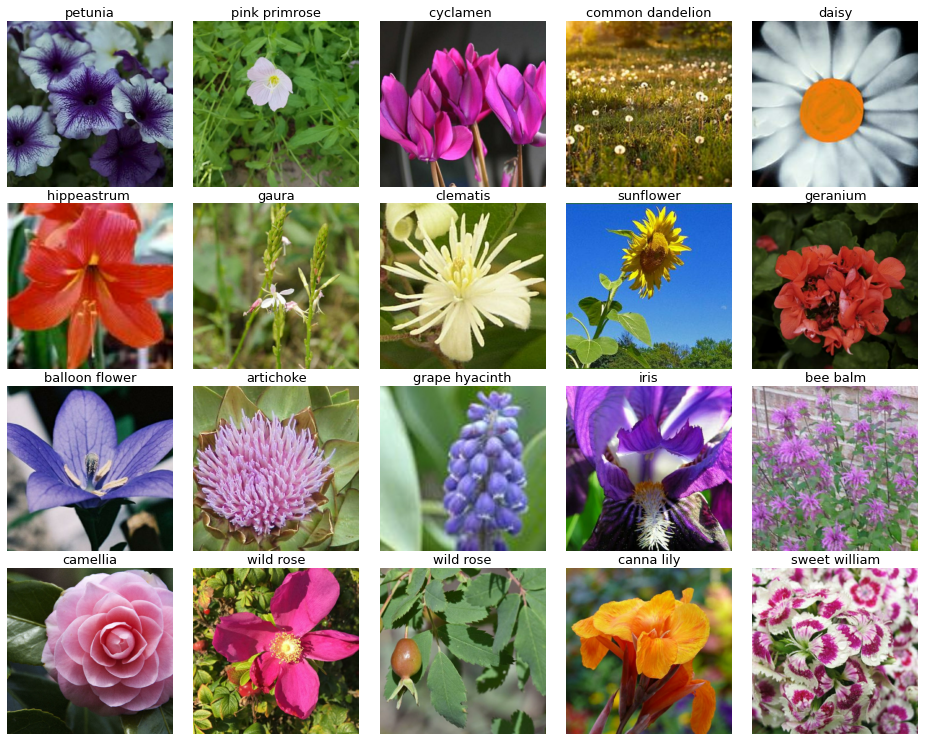

In [8]:
# Peek at training data
training_dataset = get_training_dataset()
training_dataset = training_dataset.unbatch().batch(20)
train_batch = iter(training_dataset)
display_batch_of_images(next(train_batch))

### Validation Data

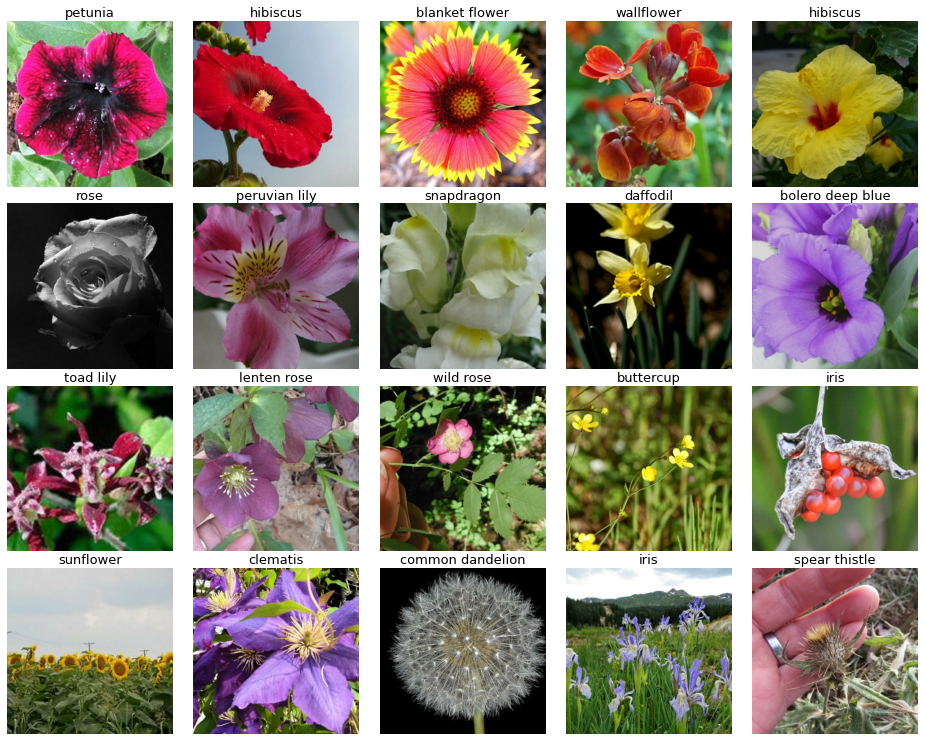

In [9]:
# Peek at validation data
validation_dataset = get_validation_dataset()
validation_dataset = validation_dataset.unbatch().batch(20)
validation_batch = iter(validation_dataset)
display_batch_of_images(next(validation_batch))

### Test Data

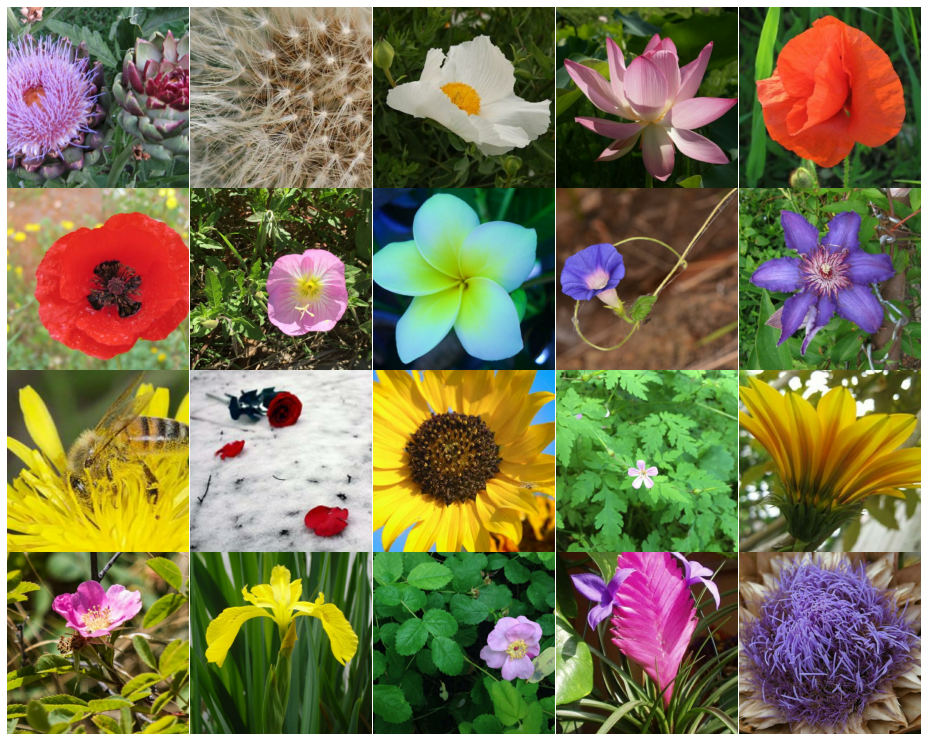

In [10]:
# Peek at test data
test_dataset = get_test_dataset()
test_dataset = test_dataset.unbatch().batch(20)
test_batch = iter(test_dataset)
display_batch_of_images(next(test_batch))

# Visualization - Label Distribution

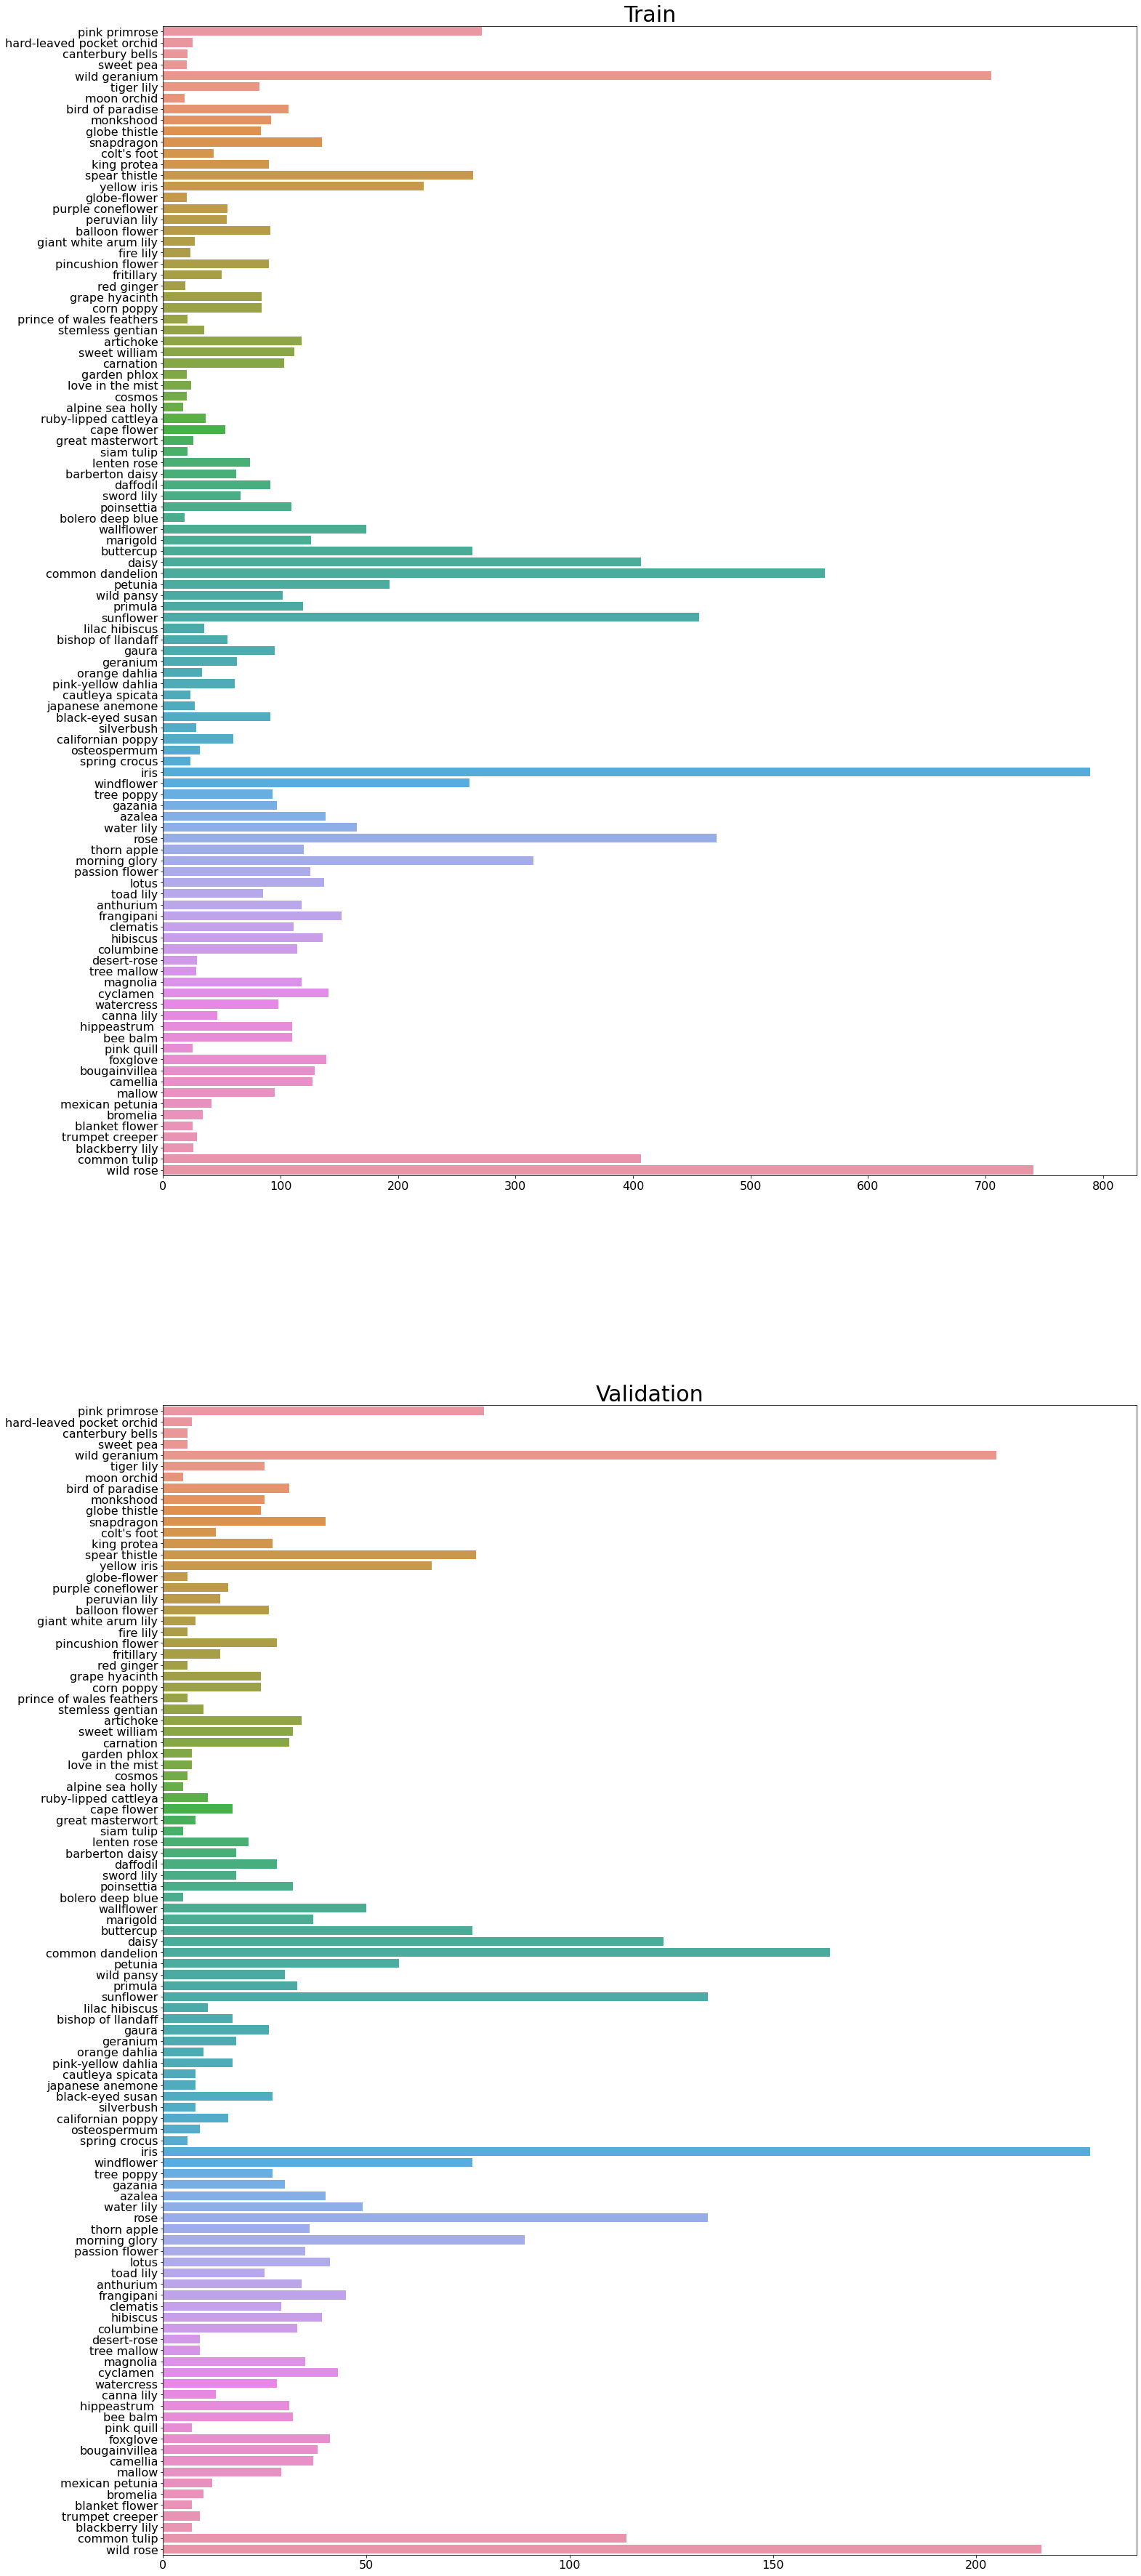

In [11]:
y_train = next(iter(training_dataset.unbatch().map(lambda image, label: label).batch(NUM_TRAINING_IMAGES))).numpy()

y_valid = next(iter(validation_dataset.unbatch().map(lambda image, label: label).batch(NUM_VALIDATION_IMAGES))).numpy()

train_agg = np.asarray([[label, (y_train == index).sum()] for index, label in enumerate(CLASSES)])
valid_agg = np.asarray([[label, (y_valid == index).sum()] for index, label in enumerate(CLASSES)])

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(24, 64))

ax1 = sns.barplot(x=train_agg[...,1], y=train_agg[...,0], order=CLASSES, ax=ax1)
ax1.set_title('Train', fontsize=30)
ax1.tick_params(labelsize=16)

ax2 = sns.barplot(x=valid_agg[...,1], y=valid_agg[...,0], order=CLASSES, ax=ax2)
ax2.set_title('Validation', fontsize=30)
ax2.tick_params(labelsize=16)

plt.show()

# Models

### DenseNet201 pre-trained with *imagenet* dataset

In [12]:
with strategy.scope():
    dn201 = tf.keras.applications.DenseNet201(weights='imagenet', include_top=False, input_shape=[*IMAGE_SIZE, 3])
    dn201.trainable = True # Full Training
    
    model_densenet201 = tf.keras.Sequential([
        dn201,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(len(CLASSES), activation='softmax')
    ])
        
model_densenet201.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False),
    loss = 'sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy']
)
model_densetnet201.summary()

74842112/74836368 [==============================] - 3s 0us/step


NameError: name 'model_densetnet201' is not defined

### EfficientNet-B7 pre-trained with *noisy-student* dataset

In [13]:
with strategy.scope():
    enb7 = efn.EfficientNetB7(weights='noisy-student', include_top=False, input_shape=[*IMAGE_SIZE, 3])
    enb7.trainable = True # Full Training
    
    model_efficientnetb7 = tf.keras.Sequential([
        enb7,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(len(CLASSES), activation='softmax')
    ])
        
model_efficientnetb7.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False),
    loss = 'sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy']
)
model_efficientnetb7.summary()

258072576/258068648 [==============================] - 8s 0us/step
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b7 (Model)      (None, 16, 16, 2560)      64097680  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2560)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 104)               266344    
Total params: 64,364,024
Trainable params: 64,053,304
Non-trainable params: 310,720
_________________________________________________________________


### Using Learning Rate Schedular and Early Stopping Callbacks.

In [14]:
LR_START = 0.0001
LR_MAX = 0.00005 * strategy.num_replicas_in_sync
LR_MIN = 0.00001
LR_RAMPUP_EPOCHS = 4
LR_SUSTAIN_EPOCHS = 4
LR_EXP_DECAY = .8

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return lr
    
lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=True)

es_callback = tf.keras.callbacks.EarlyStopping(min_delta=0, patience=10, verbose=1, mode='auto', restore_best_weights=True)

# Training

Training the DenseNet201 model for 30 epochs

In [15]:
if USE_VALIDATION_DATA:
    history_densenet201 = model_densenet201.fit(get_training_dataset(), steps_per_epoch=STEPS_PER_EPOCH, epochs=30, validation_data=get_validation_dataset(), callbacks = [lr_callback, es_callback])
else:
    history_densenet201 = model_densenet201.fit(get_training_dataset(), steps_per_epoch=STEPS_PER_EPOCH, epochs=30, callbacks = [lr_callback]).history

Train for 99 steps

Epoch 00001: LearningRateScheduler reducing learning rate to 0.0001.
Epoch 1/30
99/99 [==============================] - 419s 4s/step - loss: 2.0994 - sparse_categorical_accuracy: 0.5568 - val_loss: 1.3215 - val_sparse_categorical_accuracy: 0.6595

Epoch 00002: LearningRateScheduler reducing learning rate to 0.00017500000000000003.
Epoch 2/30
99/99 [==============================] - 73s 742ms/step - loss: 0.6914 - sparse_categorical_accuracy: 0.8548 - val_loss: 0.6316 - val_sparse_categorical_accuracy: 0.8384

Epoch 00003: LearningRateScheduler reducing learning rate to 0.00025.
Epoch 3/30
99/99 [==============================] - 73s 733ms/step - loss: 0.3627 - sparse_categorical_accuracy: 0.9211 - val_loss: 0.5316 - val_sparse_categorical_accuracy: 0.8491

Epoch 00004: LearningRateScheduler reducing learning rate to 0.00032500000000000004.
Epoch 4/30
99/99 [==============================] - 70s 703ms/step - loss: 0.2308 - sparse_categorical_accuracy: 0.9514 - val_l

Training the EfficientNet-B7 model for 40 epochs

In [16]:
if USE_VALIDATION_DATA:
    history_efficientnetb7 = model_efficientnetb7.fit(get_training_dataset(), steps_per_epoch=STEPS_PER_EPOCH, epochs=40, validation_data=get_validation_dataset(), callbacks = [lr_callback, es_callback])
else:
    history_efficientnetb7 = model_efficientnetb7.fit(get_training_dataset(), steps_per_epoch=STEPS_PER_EPOCH, epochs=40, callbacks = [lr_callback])

Train for 99 steps

Epoch 00001: LearningRateScheduler reducing learning rate to 0.0001.
Epoch 1/40
99/99 [==============================] - 423s 4s/step - loss: 3.6313 - sparse_categorical_accuracy: 0.2386 - val_loss: 2.5181 - val_sparse_categorical_accuracy: 0.4267

Epoch 00002: LearningRateScheduler reducing learning rate to 0.00017500000000000003.
Epoch 2/40
99/99 [==============================] - 105s 1s/step - loss: 1.4977 - sparse_categorical_accuracy: 0.6496 - val_loss: 0.7252 - val_sparse_categorical_accuracy: 0.8384

Epoch 00003: LearningRateScheduler reducing learning rate to 0.00025.
Epoch 3/40
99/99 [==============================] - 105s 1s/step - loss: 0.6232 - sparse_categorical_accuracy: 0.8598 - val_loss: 0.3714 - val_sparse_categorical_accuracy: 0.9073

Epoch 00004: LearningRateScheduler reducing learning rate to 0.00032500000000000004.
Epoch 4/40
99/99 [==============================] - 105s 1s/step - loss: 0.4032 - sparse_categorical_accuracy: 0.9053 - val_loss: 0

# Model Loss Graphs

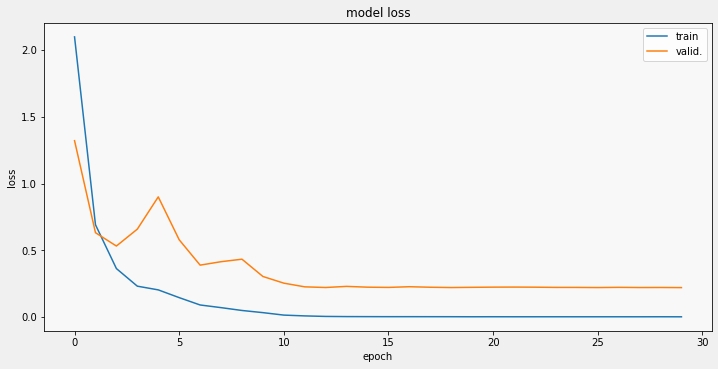

In [17]:
if USE_VALIDATION_DATA:
    display_training_curves(history_densenet201.history['loss'], history_densenet201.history['val_loss'], 'loss', 211)


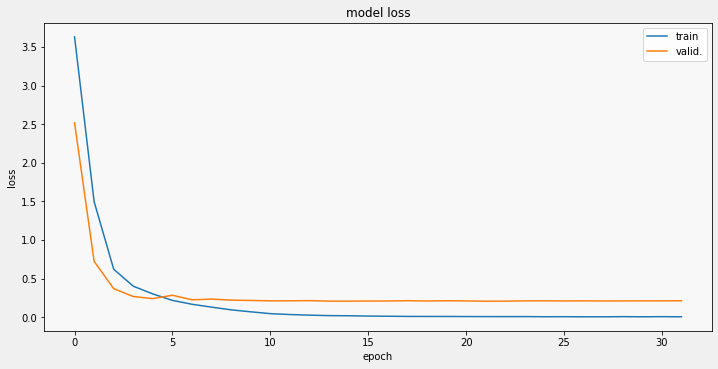

In [18]:
if USE_VALIDATION_DATA:
    display_training_curves(history_efficientnetb7.history['loss'], history_efficientnetb7.history['val_loss'], 'loss', 211)

In [19]:
if USE_VALIDATION_DATA:    
    cmdataset = get_validation_dataset(ordered=True) # since we are splitting the dataset and iterating separately on images and labels, order matters.
    images_ds = cmdataset.map(lambda image, label: image)
    labels_ds = cmdataset.map(lambda image, label: label).unbatch()
    cm_correct_labels = next(iter(labels_ds.batch(NUM_VALIDATION_IMAGES))).numpy() # get everything as one batch
    cm_probabilities = model_densenet201.predict(images_ds) * 0.4 + model_efficientnetb7.predict(images_ds) * 0.6
    cm_predictions = np.argmax(cm_probabilities, axis=-1)
    print("Correct   labels: ", cm_correct_labels.shape, cm_correct_labels)
    print("Predicted labels: ", cm_predictions.shape, cm_predictions)

Correct   labels:  (3712,) [ 50  13  74 ... 102  48  67]
Predicted labels:  (3712,) [ 50  13  74 ... 102  48  67]


## Confusion Matrix

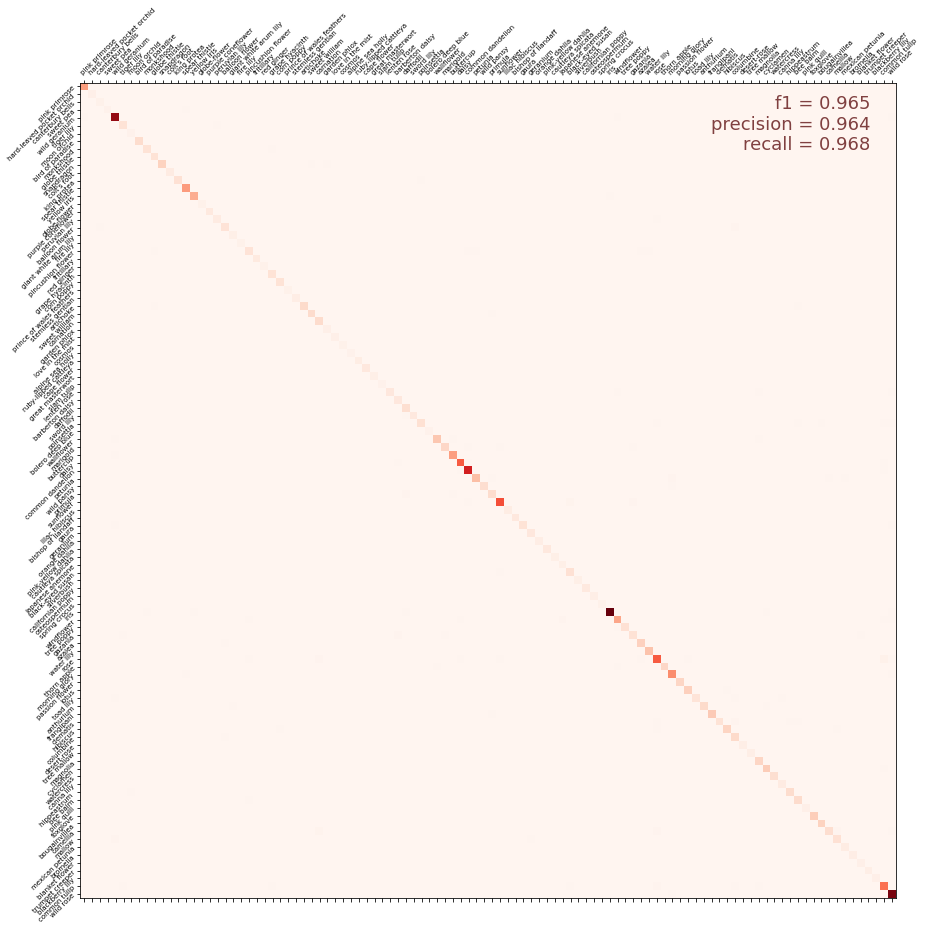

f1 score: 0.965, precision: 0.964, recall: 0.968


In [20]:
if USE_VALIDATION_DATA: 
    cmat = confusion_matrix(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)))
    score = f1_score(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)), average='macro')
    precision = precision_score(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)), average='macro')
    recall = recall_score(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)), average='macro')
    display_confusion_matrix(cmat, score, precision, recall)
    print('f1 score: {:.3f}, precision: {:.3f}, recall: {:.3f}'.format(score, precision, recall))

# Prediction

In [21]:
test_ds = get_test_dataset(ordered=True) # since we are splitting the dataset and iterating separately on images and ids, order matters.

print('Computing predictions...')
test_images_ds = test_ds.map(lambda image, idnum: image)
probabilities = model_densenet201.predict(test_images_ds) * 0.4 + model_efficientnetb7.predict(test_images_ds) * 0.6
predictions = np.argmax(probabilities, axis=-1)
print(predictions)

print('Generating submission.csv file...')
test_ids_ds = test_ds.map(lambda image, idnum: idnum).unbatch()
test_ids = next(iter(test_ids_ds.batch(NUM_TEST_IMAGES))).numpy().astype('U') # all in one batch
np.savetxt('submission.csv', np.rec.fromarrays([test_ids, predictions]), fmt=['%s', '%d'], delimiter=',', header='id,label', comments='')
!head submission.csv

Computing predictions...
[ 67  28  83 ...  94 102  62]
Generating submission.csv file...
id,label
252d840db,67
1c4736dea,28
c37a6f3e9,83
00e4f514e,103
59d1b6146,46
8d808a07b,53
aeb67eefb,52
53cfc6586,29
aaa580243,82


## Visualization for prediction of Validation Dataset


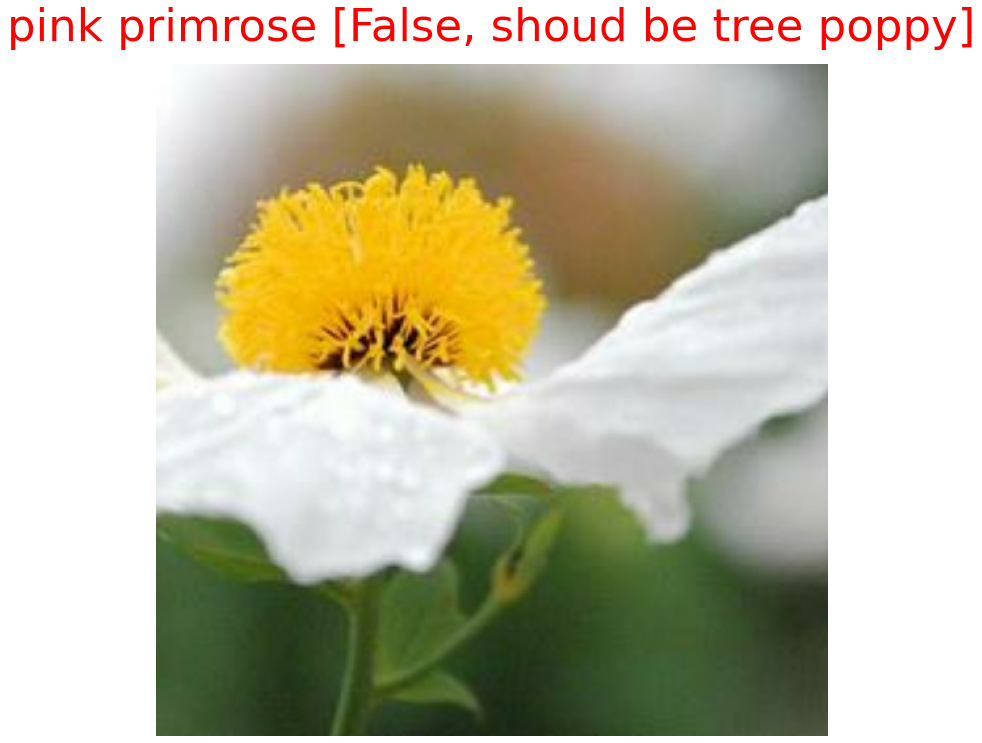

In [22]:
if USE_VALIDATION_DATA:
    validation_dataset = validation_dataset.unbatch().batch(1)
    batch = iter(validation_dataset)
    images, labels = next(batch)
    probabilities = model_densenet201.predict(images) * 0.4 + model_efficientnetb7.predict(images) * 0.6
    predictions = np.argmax(probabilities, axis=-1)
    display_batch_of_images((images, labels), predictions)